In [ ]:
firstTime = True
if firstTime:
    print("First time setup")
    %pip install IPython
    %pip install pandas
    %pip install numpy
    %pip install tqdm
    %pip install scikit-learn
    %pip install torch
    %pip install matplotlib
    %pip install seaborn
    %pip install tabulate
    %pip install ipywidgets
    %pip install --upgrade ipywidgets
    %pip install --upgrade jupyter
    firstTime = False

In [1]:
# importing datasets
import pandas as pd
import numpy as np
from tabulate import tabulate
books_raw_df = pd.read_csv('data/Books.csv')
book_reviews_raw_df = pd.read_csv('data/Ratings.csv')
books_users_raw_df = pd.read_csv('data/Users.csv')

C:\Users\elley\AppData\Local\Temp\ipykernel_27020\2446763230.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_raw_df = pd.read_csv('data/Books.csv')


In [2]:
# printing the shape of the dataframes
print(f'Books dataframe shape: {books_raw_df.shape}')
print(f'Reviews dataframe shape: {book_reviews_raw_df.shape}')
print(f'Users dataframe shape: {books_users_raw_df.shape}')

print(tabulate(books_raw_df.head(), headers='keys', tablefmt='psql'))
print(tabulate(book_reviews_raw_df.head(), headers='keys', tablefmt='psql'))
print(tabulate(books_users_raw_df.head(), headers='keys', tablefmt='psql'))

Books dataframe shape: (271360, 8)
Reviews dataframe shape: (1149780, 3)
Users dataframe shape: (278858, 3)
+----+------------+----------------------------------------------------------------------------------------------------+----------------------+-----------------------+----------------------------+--------------------------------------------------------------+--------------------------------------------------------------+--------------------------------------------------------------+
|    |       ISBN | Book-Title                                                                                         | Book-Author          |   Year-Of-Publication | Publisher                  | Image-URL-S                                                  | Image-URL-M                                                  | Image-URL-L                                                  |
|----+------------+----------------------------------------------------------------------------------------------------+

In [146]:
# Set the desired size of the smaller dataset
num_books = 100
num_total_ratings = 200

# getting 100 top rated books
top_rated_books = book_reviews_raw_df['ISBN'].value_counts().head(num_books).index

# Sort the books by ISBN
full_books_df = books_raw_df[books_raw_df['ISBN'].isin(top_rated_books)]

# dropping image URL features 
full_books_df = full_books_df.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'])

# Get the top n books
sampled_books_df = full_books_df

# Create temp df that only has book_isbn of the sampled books
book_isbn = sampled_books_df['ISBN'].unique()

# Get all ratings for the books
full_ratings_df = book_reviews_raw_df[book_reviews_raw_df['ISBN'].isin(book_isbn)]

# Get n ratings for book
sampled_ratings_df = full_ratings_df.groupby('ISBN').head(num_total_ratings)

# Merge ratings with users
sampled_ratings_df = pd.merge(sampled_ratings_df, books_users_raw_df, on='User-ID', how='left')

# drop ratings that don't have an age
sampled_ratings_df = sampled_ratings_df.dropna(subset=['Age'])

# drop location column 
sampled_ratings_df = sampled_ratings_df.drop(columns=['Location'])

# print the first row of each dataframe
print(tabulate(sampled_books_df.head(1), headers='keys', tablefmt='psql'))
print(tabulate(sampled_ratings_df.head(1), headers='keys', tablefmt='psql'))

book_titles = sampled_books_df.set_index('ISBN')['Book-Title'].to_dict()
num_total_books = sampled_books_df['ISBN'].nunique()
num_total_users = sampled_ratings_df['User-ID'].nunique()
num_total_ratings = sampled_ratings_df['Book-Rating'].count()

print(f'Sampled Books dataframe shape: {sampled_books_df.shape}')
print(f'Sampled Ratings dataframe shape: {sampled_ratings_df.shape}')

print(f'Number of books: {num_total_books}')
print(f'Number of ratings: {num_total_ratings}')
print(f'Number of users: {num_total_users}')

+----+------------+---------------+---------------+-----------------------+-------------+
|    |       ISBN | Book-Title    | Book-Author   |   Year-Of-Publication | Publisher   |
|----+------------+---------------+---------------+-----------------------+-------------|
| 18 | 0440234743 | The Testament | John Grisham  |                  1999 | Dell        |
+----+------------+---------------+---------------+-----------------------+-------------+
+----+-----------+------------+---------------+-------+
|    |   User-ID |       ISBN |   Book-Rating |   Age |
|----+-----------+------------+---------------+-------|
|  1 |    276847 | 0446364193 |             0 |    27 |
+----+-----------+------------+---------------+-------+
Sampled Books dataframe shape: (99, 5)
Sampled Ratings dataframe shape: (13800, 4)
Number of books: 99
Number of ratings: 13800
Number of users: 5334


In [147]:
# check all dataframes for missing values
print(sampled_books_df.isnull().sum())
print(sampled_ratings_df.isnull().sum())

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64
User-ID        0
ISBN           0
Book-Rating    0
Age            0
dtype: int64


In [148]:
import torch
import torch.nn as nn

class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, n_factors=20, user_feature_dim=10):
        super().__init__()
        
        # Embeddings for users and items
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        
        self.user_features_layer = nn.Linear(user_feature_dim, n_factors)
        
        # Initialize embeddings and layers
        self.user_factors.weight.data.uniform_(0, 0.05)
        self.item_factors.weight.data.uniform_(0, 0.05)
        self.user_features_layer.weight.data.uniform_(0, 0.05)
    
    def forward(self, data):
        # Unpack data
        items = data[:, 0].long()          
        user_ids = data[:, 1].long()       
        user_features = data[:, 2:]
        
        # Retrieve user and item embeddings
        user_embeddings = self.user_factors(user_ids)
        item_embeddings = self.item_factors(items)
        
        # Apply the linear layer to user features
        user_features_embeddings = self.user_features_layer(user_features.float()) 
        
        # Combine user ID embeddings with user features embeddings
        combined_user_embeddings = user_embeddings + user_features_embeddings 

        # Perform element-wise multiplication and sum along the appropriate dimension
        interaction = (combined_user_embeddings * item_embeddings).sum(dim=1)
        
        return interaction


In [149]:
from torch.utils.data.dataloader import Dataset
from torch.utils.data import DataLoader

class PreProcessor(Dataset):
    def __init__(self, books_df, ratings_df):
        # copy ratings dataframe
        self.ratings = ratings_df.copy()

        # getting all user ids and books isbns
        users = ratings_df['User-ID'].unique()
        videogames = books_df['ISBN'].unique()

        # creating dictionaries for mappings
        self.user_to_index = {user: idx for idx, user in enumerate(users)}
        self.game_to_index = {game: idx for idx, game in enumerate(videogames)}
        self.index_to_user = {idx: user for user, idx in self.user_to_index.items()}
        self.index_to_game = {idx: game for game, idx in self.game_to_index.items()}

        # mapping user and books isbns to indexes
        self.ratings['ISBN'] = ratings_df['ISBN'].apply(lambda x: self.game_to_index[x])
        self.ratings['User-ID'] = ratings_df['User-ID'].apply(lambda x: self.user_to_index[x])

        # creating x and y tensors
        self.x = self.ratings[['ISBN','User-ID','Age']].values
        self.y = self.ratings['Book-Rating'].values

        self.x, self.y = torch.tensor(self.x), torch.tensor(self.y)
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [187]:
# setting up hyperparameters
epochs = 200
batch_size = 132
n_factors = 2
book_feature_dim = 1

# seeing if GPU is available
cuda = torch.cuda.is_available()

# create model
model = MatrixFactorization(num_total_users, num_total_books, n_factors, book_feature_dim)
print(model)

if cuda:
    print("Can run on GPU")
    torch.cuda.empty_cache()
    model = model.cuda()

# print model parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

# loss function and optimizer
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# setting up training data
train_set = PreProcessor(sampled_books_df, sampled_ratings_df)
print("\nSample Tensor:",train_set[0])
train_loader = DataLoader(train_set, batch_size, shuffle=True)

# recording starting embeddings
starting_videogame_embeddings = model.item_factors.weight.data.cpu().numpy().copy()

MatrixFactorization(
  (user_factors): Embedding(5334, 2)
  (item_factors): Embedding(99, 2)
  (user_features_layer): Linear(in_features=1, out_features=2, bias=True)
)
user_factors.weight tensor([[0.0400, 0.0117],
        [0.0339, 0.0078],
        [0.0287, 0.0111],
        ...,
        [0.0027, 0.0090],
        [0.0110, 0.0166],
        [0.0007, 0.0436]])
item_factors.weight tensor([[3.5240e-02, 1.1255e-02],
        [1.7024e-03, 1.9302e-02],
        [4.6179e-02, 4.9525e-02],
        [4.1282e-02, 9.5546e-03],
        [1.0257e-02, 1.2942e-02],
        [2.9536e-02, 3.2861e-02],
        [2.6812e-02, 3.8330e-02],
        [4.0111e-02, 7.2528e-04],
        [3.1650e-02, 7.1991e-03],
        [1.4002e-02, 1.6915e-02],
        [3.6714e-03, 1.7086e-02],
        [2.2829e-02, 2.9327e-02],
        [1.4644e-02, 4.7932e-02],
        [3.9207e-02, 1.7983e-02],
        [4.5108e-02, 2.0505e-02],
        [2.6041e-02, 2.7328e-02],
        [2.3524e-02, 3.8470e-02],
        [1.3084e-02, 3.2695e-02],
        [

In [188]:
from tqdm.notebook import tqdm_notebook as tqdm 

# matrix factorization training loop
for epoch in tqdm(range(epochs)):
    losses = []

    for x, y in train_loader:
        if cuda:
            x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        y_hat = model(x)
        loss = loss_func(y_hat.squeeze(), y.type(torch.float32))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch} - loss: {sum(losses)/len(losses)}')

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0 - loss: 25.60488735380627
Epoch 1 - loss: 19.750966553460984
Epoch 2 - loss: 17.933707527887254
Epoch 3 - loss: 17.77338004339309
Epoch 4 - loss: 17.70423992701939
Epoch 5 - loss: 17.64941083817255
Epoch 6 - loss: 17.590644246055966
Epoch 7 - loss: 17.57531620207287
Epoch 8 - loss: 17.494348607744488
Epoch 9 - loss: 17.44899629865374
Epoch 10 - loss: 17.399849065144856
Epoch 11 - loss: 17.375223405020577
Epoch 12 - loss: 17.28663309188116
Epoch 13 - loss: 17.24031739007859
Epoch 14 - loss: 17.186020487830753
Epoch 15 - loss: 17.127770006088983
Epoch 16 - loss: 17.07436028435117
Epoch 17 - loss: 17.007953062511625
Epoch 18 - loss: 16.94024361201695
Epoch 19 - loss: 16.86461264292399
Epoch 20 - loss: 16.799895695277623
Epoch 21 - loss: 16.725552440824963
Epoch 22 - loss: 16.663855416434153
Epoch 23 - loss: 16.576545570010232
Epoch 24 - loss: 16.499865786234537
Epoch 25 - loss: 16.41073442186628
Epoch 26 - loss: 16.3412901197161
Epoch 27 - loss: 16.24175516764323
Epoch 28 - loss: 

In [189]:
# converting factor weights tensor to numpy array
trained_videogame_embeddings = model.item_factors.weight.data.cpu().numpy()

# Matrix Factorization Heatmap Visualization

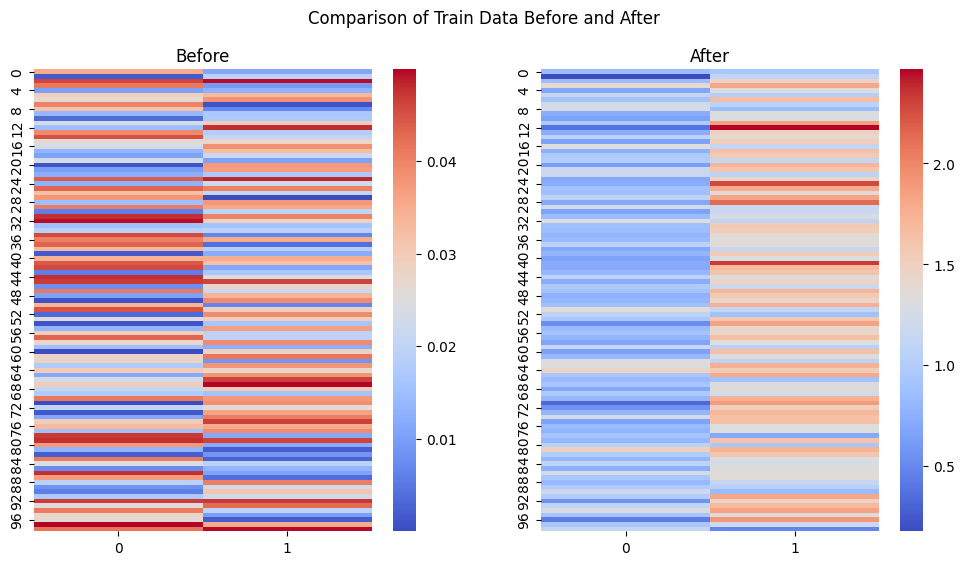

In [190]:
# matrix factorization heatmap
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the heatmap of the original train_data
sns.heatmap(starting_videogame_embeddings, cmap='coolwarm', ax=axs[0])
axs[0].set_title('Before')

# Plot the heatmap of the modified train_data
sns.heatmap(trained_videogame_embeddings, cmap='coolwarm', ax=axs[1])
axs[1].set_title('After')

# Set the overall title for the figure
fig.suptitle('Comparison of Train Data Before and After')

# Display the figure
plt.show()

# Elbow Method Visualization

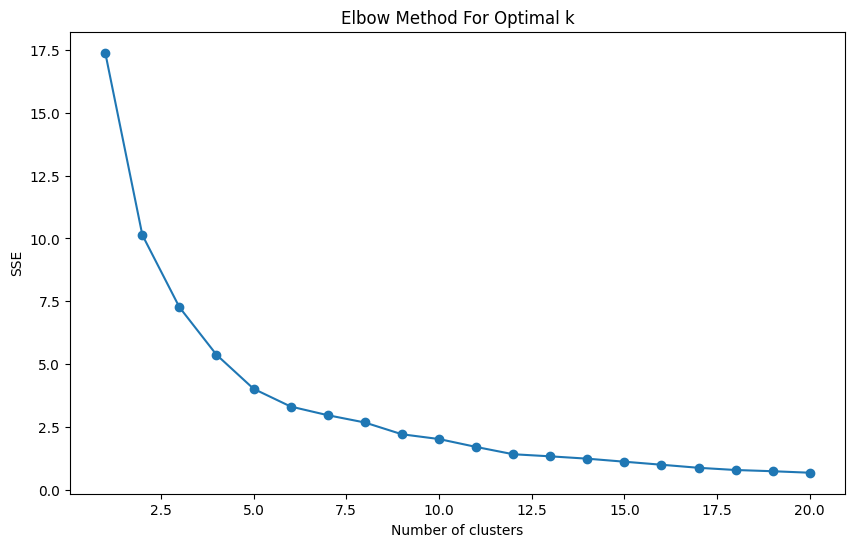

In [191]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Determine the optimal number of clusters using the elbow method
sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(trained_videogame_embeddings)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()


# Silhouette Analysis Visualization

For n_clusters = 2, the average silhouette_score is : 0.3625537157058716
For n_clusters = 3, the average silhouette_score is : 0.3456917703151703
For n_clusters = 4, the average silhouette_score is : 0.37548792362213135
For n_clusters = 5, the average silhouette_score is : 0.38111716508865356
For n_clusters = 6, the average silhouette_score is : 0.34998488426208496
For n_clusters = 7, the average silhouette_score is : 0.329850435256958
For n_clusters = 8, the average silhouette_score is : 0.31283441185951233
For n_clusters = 9, the average silhouette_score is : 0.3392322063446045


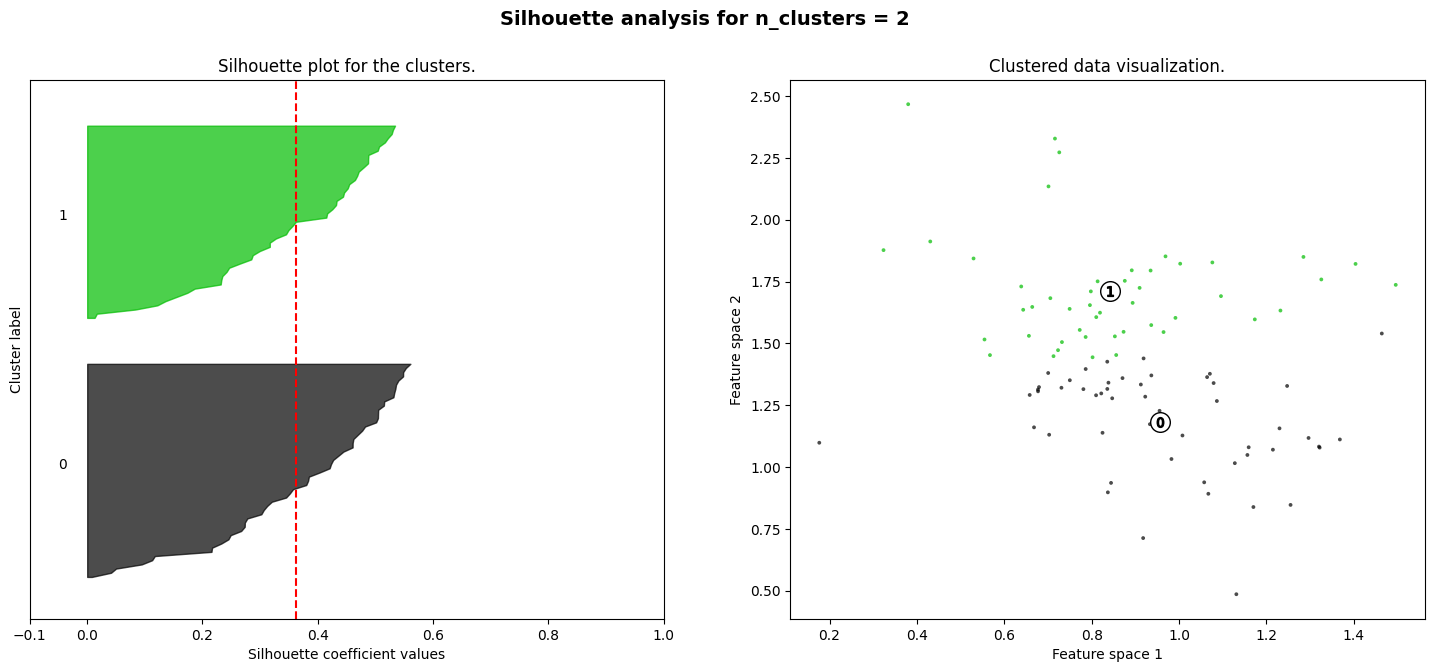

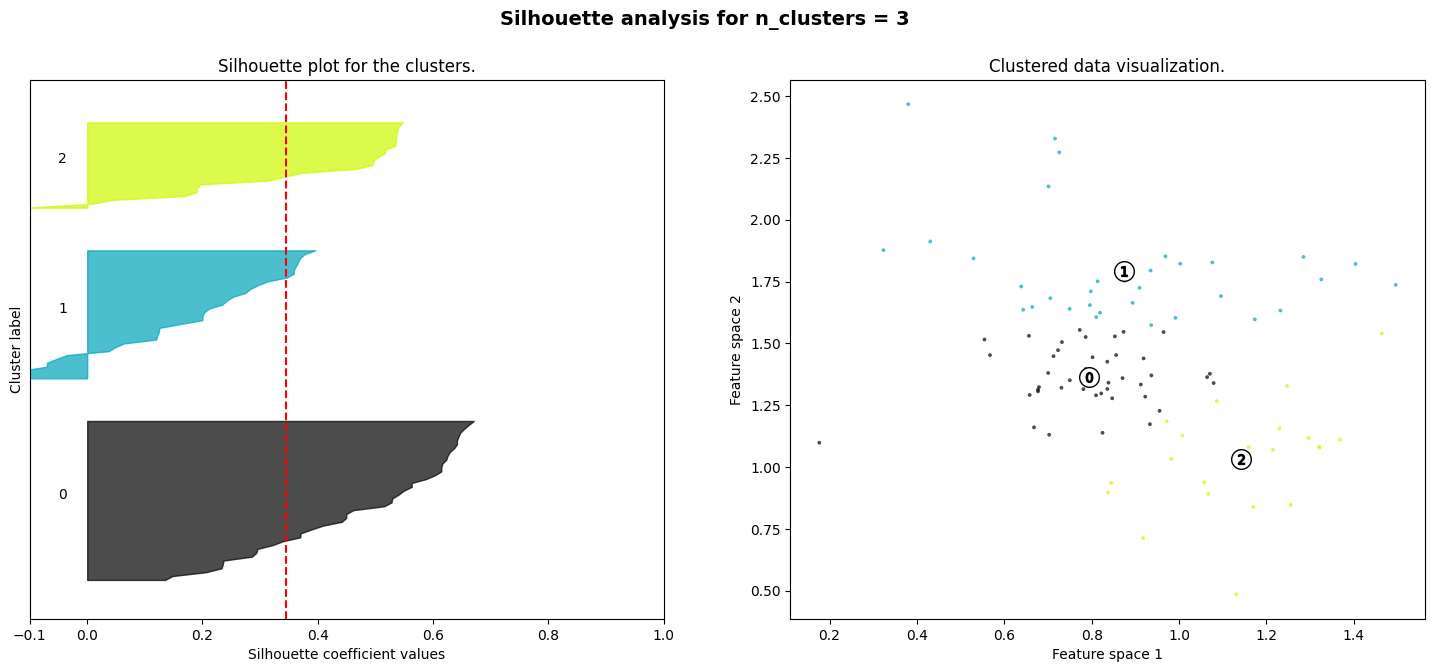

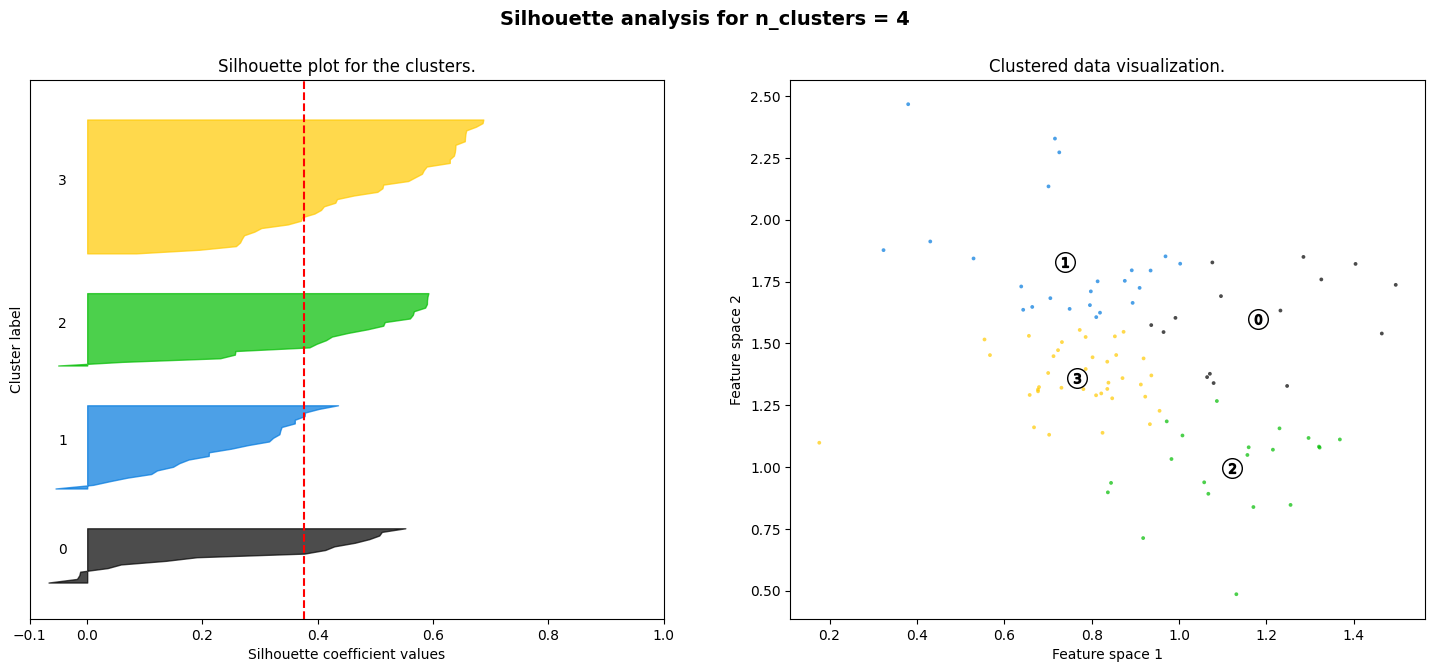

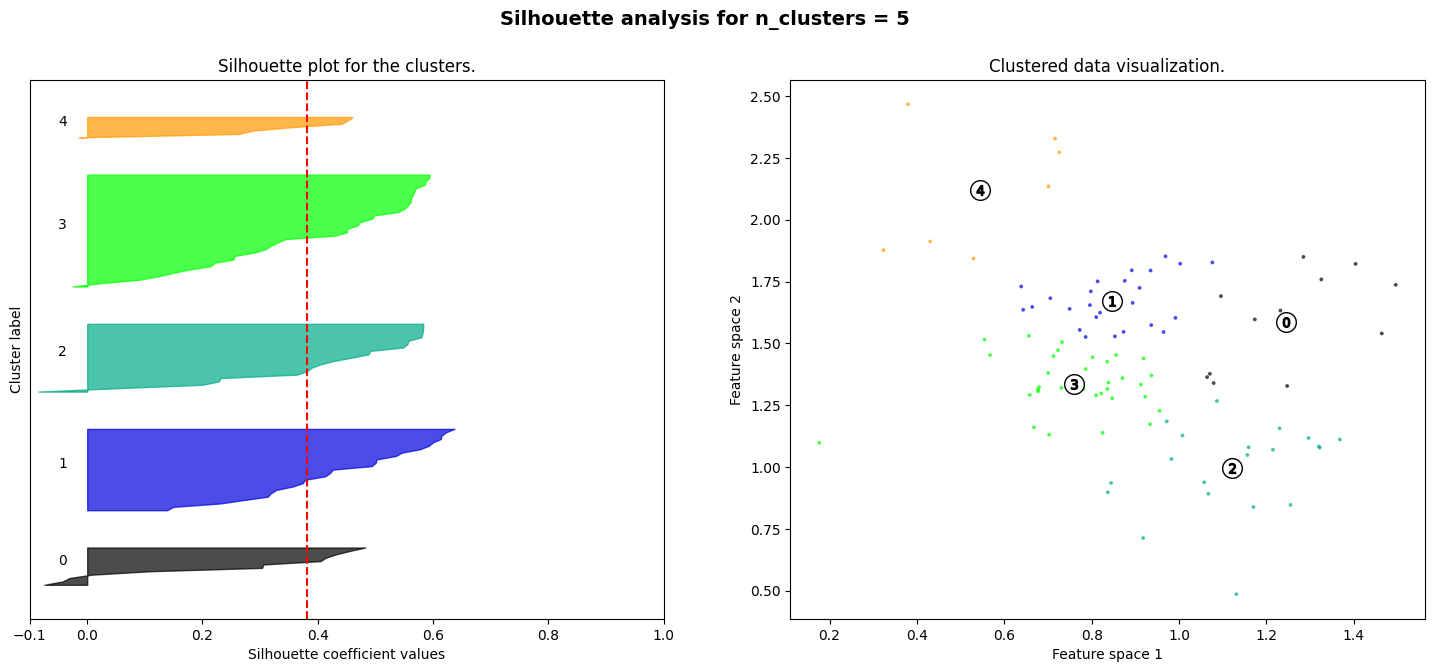

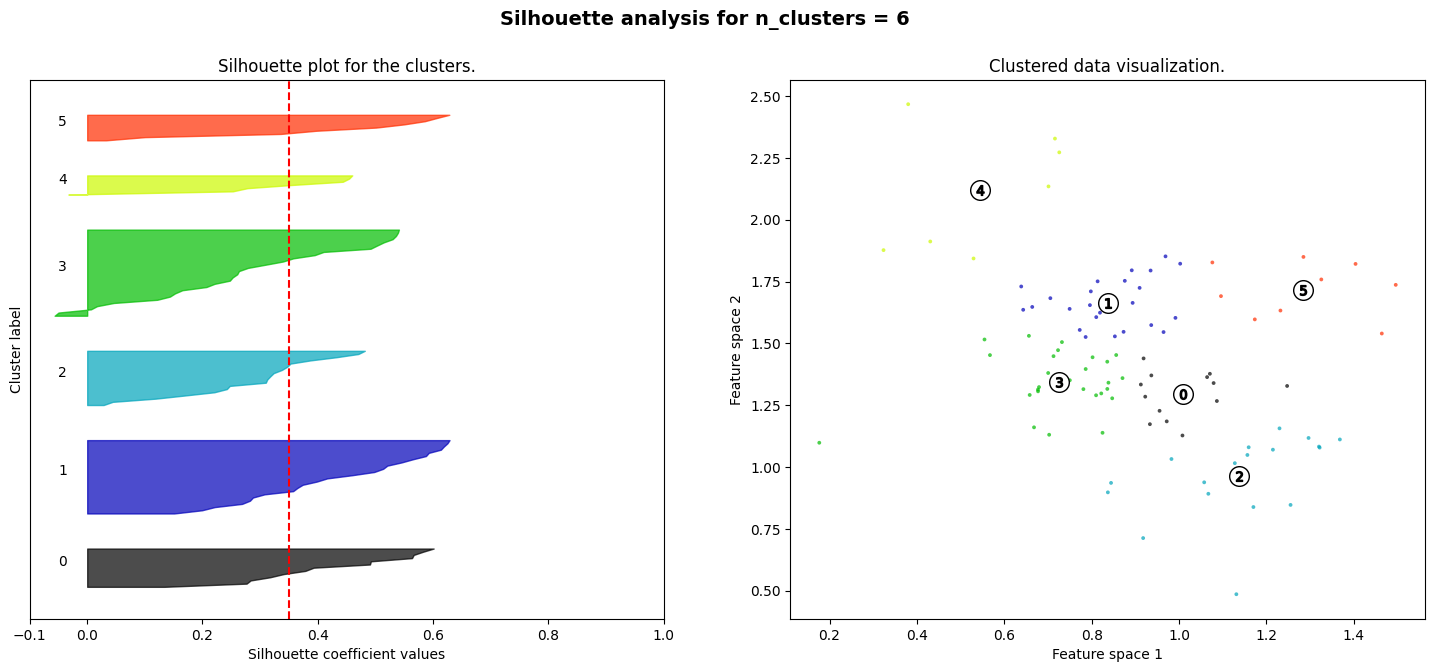

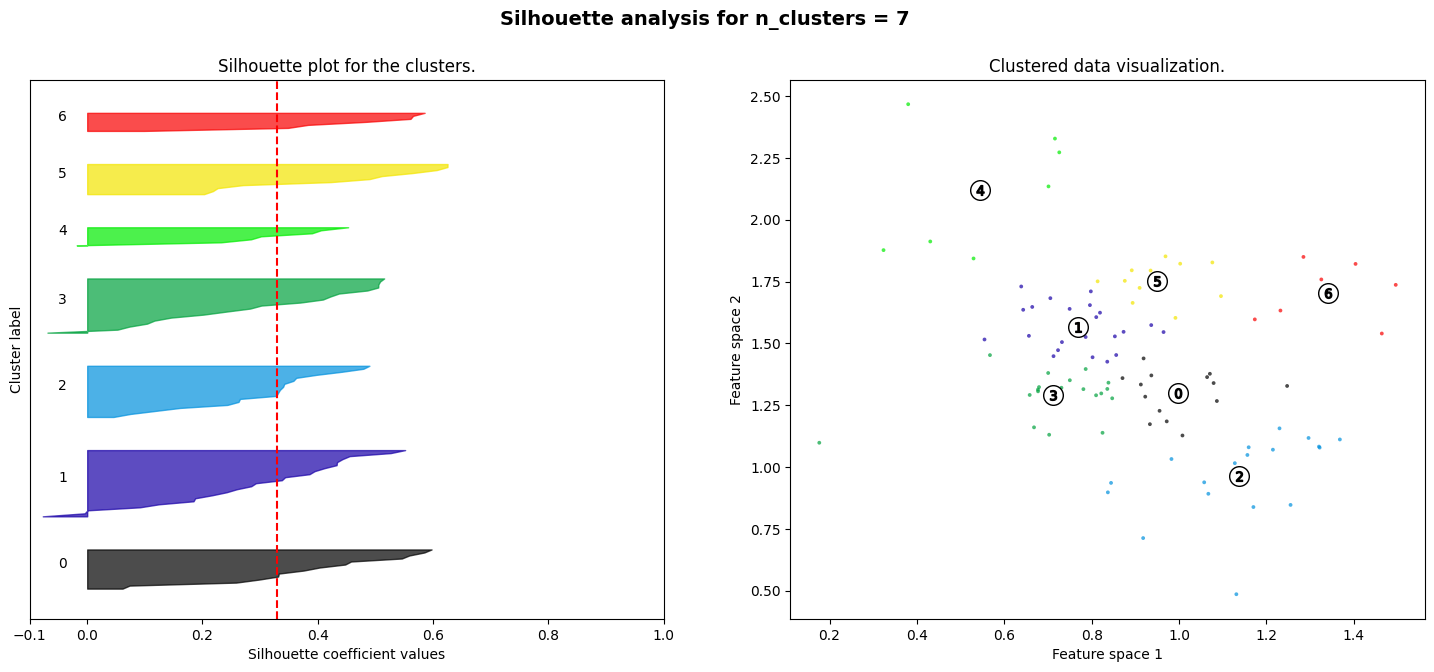

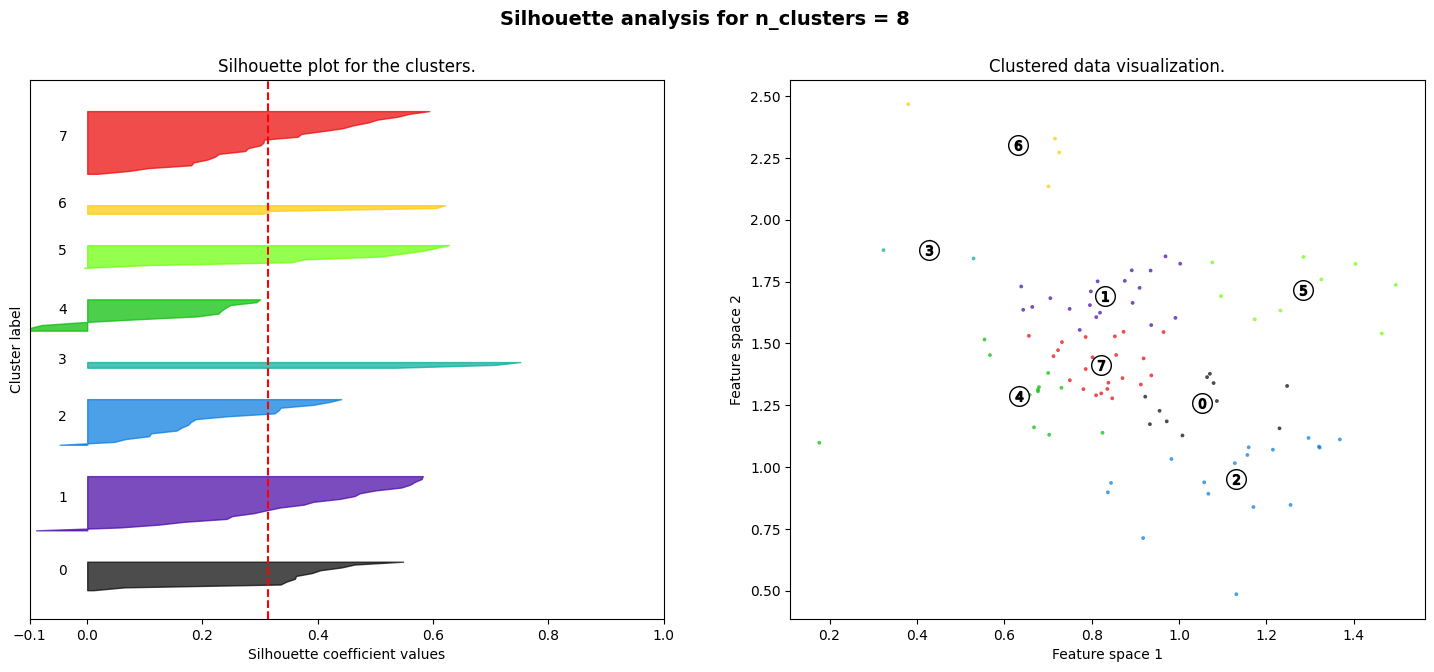

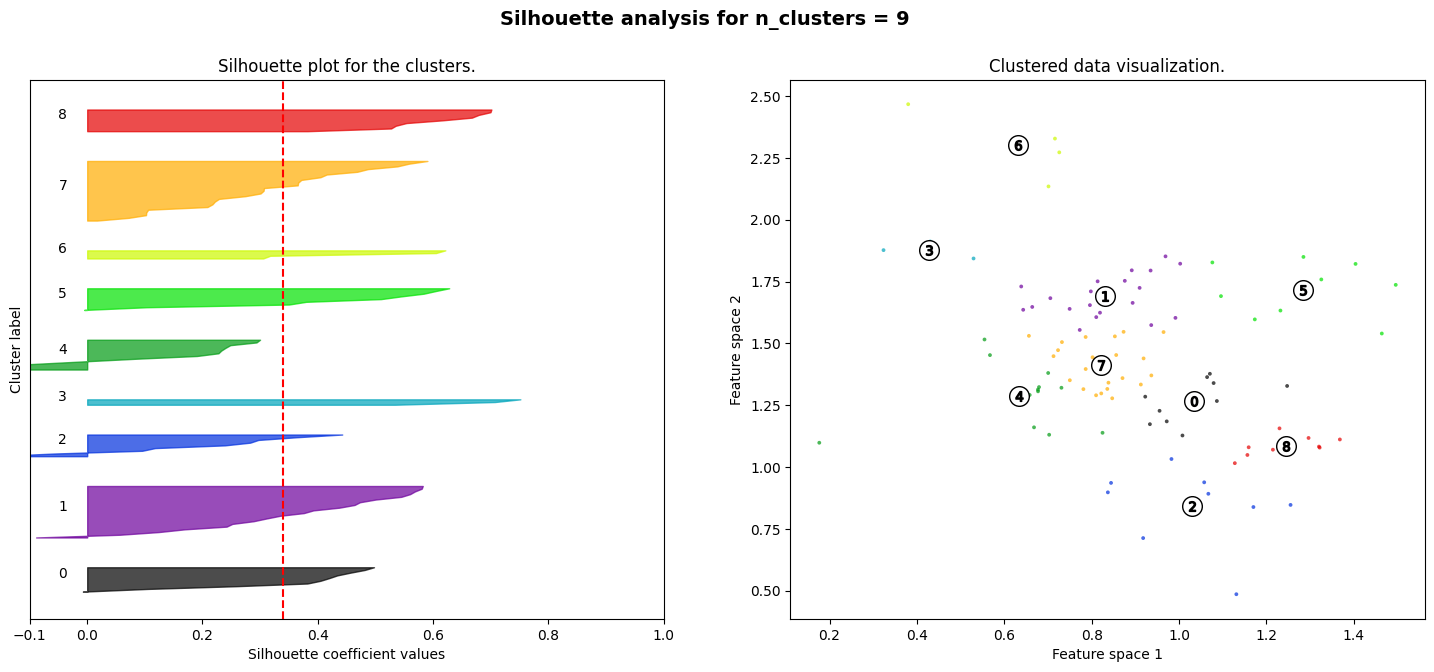

In [192]:
from sklearn.metrics import silhouette_score, silhouette_samples

# identify the optimal number of clusters and accuracy via the silhouette score
for k in range(2, 10):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(trained_videogame_embeddings) + (k + 1) * 10])

    clusterer = KMeans(n_clusters=k, random_state=42)
    cluster_labels = clusterer.fit_predict(trained_videogame_embeddings)

    silhouette_average = silhouette_score(trained_videogame_embeddings, cluster_labels)
    print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_average}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(trained_videogame_embeddings, cluster_labels)
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax1.set_title("Silhouette plot for the clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_average, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(trained_videogame_embeddings[:, 0], trained_videogame_embeddings[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("Clustered data visualization.")
    ax2.set_xlabel("Feature space 1")
    ax2.set_ylabel("Feature space 2")

    plt.suptitle(("Silhouette analysis for n_clusters = %d" % k), fontsize=14, fontweight='bold')

plt.show()

In [199]:
from sklearn.cluster import KMeans
clusters = 7

# fitting kmeans model
kmeans = KMeans(n_clusters=clusters, random_state=42).fit(trained_videogame_embeddings)

In [200]:
# Initialize a list to hold cluster information
cluster_info = []

# Iterate over clusters
for i in range(clusters):
    cluster_games = []
    for gameIDX in np.where(kmeans.labels_ == i)[0]:
        gameID = train_set.index_to_game[gameIDX]
        cluster_games.append(book_titles[gameID])
    cluster_info.append({'Cluster': f'Cluster {i}', 'Games': '\n'.join(sorted(cluster_games))})

# Print the cluster information in tabular format
print(tabulate(cluster_info, headers='keys', tablefmt='grid'))

+-----------+---------------------------------------------------------------------------+
| Cluster   | Games                                                                     |
+===========+===========================================================================+
| Cluster 0 | A Is for Alibi (Kinsey Millhone Mysteries (Paperback))                    |
|           | Confessions of a Shopaholic (Summer Display Opportunity)                  |
|           | Empire Falls                                                              |
|           | Fall On Your Knees (Oprah #45)                                            |
|           | Fast Food Nation: The Dark Side of the All-American Meal                  |
|           | The Bridges of Madison County                                             |
|           | The Chamber                                                               |
|           | The Client                                                                |
|         

# Cluster Density Visualization

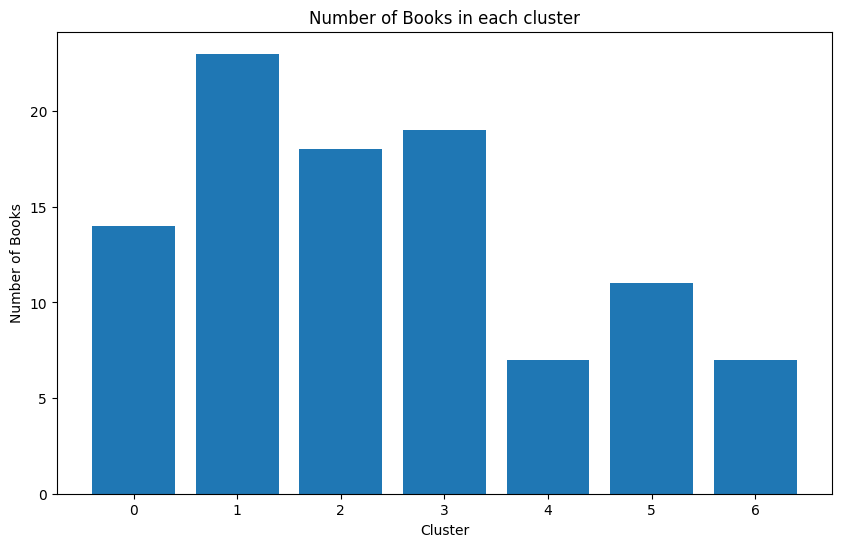

In [201]:
# Bar chart of the number of books in each cluster
plt.figure(figsize=(10, 6))
plt.bar(range(clusters), np.bincount(kmeans.labels_))
plt.xlabel('Cluster')
plt.ylabel('Number of Books')
plt.title('Number of Books in each cluster')
plt.show()

# K-means Clustering Groups Visualization

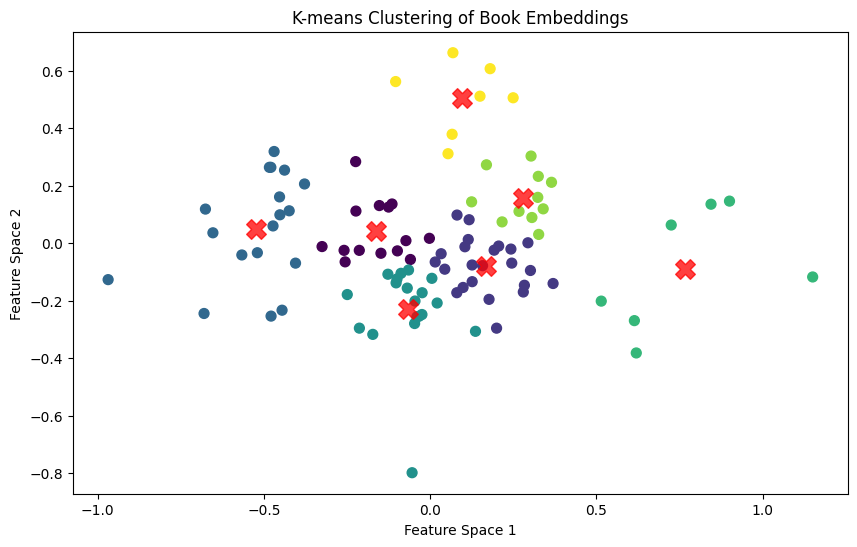

In [202]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

y_kmeans = kmeans.labels_

# Reduce dimensions with PCA for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(trained_videogame_embeddings)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Plot the centroids
centers_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', s=200, alpha=0.75, marker='X')

plt.title('K-means Clustering of Book Embeddings')
plt.xlabel('Feature Space 1')
plt.ylabel('Feature Space 2')
plt.show()

In [203]:
import numpy as np
from ipywidgets import widgets
from IPython.display import display, clear_output

# Create a dropdown widget for selecting a game
game_dropdown = widgets.Dropdown(
    options=book_titles.values(),
    description='Game:',
    disabled=False,
)

# Function to get the cluster of the selected game
def get_game_cluster(game_name):
    game_id = sampled_books_df[sampled_books_df['Book-Title'] == game_name].iloc[0]['ISBN']
    game_idx = train_set.game_to_index[game_id]
    game_embedding = trained_videogame_embeddings[game_idx].reshape(1, -1)
    cluster = kmeans.predict(game_embedding)[0]
    return cluster

# Function to get the games in the same cluster as the selected game
def get_cluster_games(cluster):
    cluster_games = []
    for gameIDX in np.where(kmeans.labels_ == cluster)[0]:
        gameID = train_set.index_to_game[gameIDX]
        cluster_games.append(book_titles[gameID])
    return cluster_games

# Function to display the games in the same cluster as the selected game
def display_cluster_games(game_name):
    cluster = get_game_cluster(game_name)
    cluster_games = get_cluster_games(cluster)
    clear_output(wait=True)  # Clear previous output
    display(game_dropdown)  # Re-display the dropdown
    print(f'Games in the same cluster as {game_name}:')
    for game in cluster_games:
        print(game)

# Create an event handler for the dropdown widget
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        display_cluster_games(change['new'])

# Attach the event handler to the dropdown widget
game_dropdown.observe(on_change, names='value')

# Display the dropdown widget
display(game_dropdown)

Dropdown(description='Game:', options=('The Testament', 'Wild Animus', 'Timeline', 'To Kill a Mockingbird', 'T…

In [204]:
# write all cells to a file
#!jupyter nbconvert --to script WGU_Capstone.ipynb